# RNN Model Applied to Cambridge

Initial explorations with the RNN model focused on Cambridge trajectories.
This was later dropped.
See the main work in file: `evaluate_rnn`

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from eval_util import *


In [2]:
HOURS_PER_DAY = 24
TIME_PERIOD_DAYS = 5

In [3]:
def read_trajectories_from_file(filename):
    """
    Returns a list of lists, where each list represents a trajectory written to file.
    Expects file format where each line is one trajectory, and places in the trajectory are delimited by spaces.
    """
    trajectories = []
    with open(filename, 'r') as f:
        for _i, line in enumerate(f):
            line = line.strip()
            line = line.split()
            parse_line = [int(x) for x in line]
            trajectories.append(parse_line)
    return trajectories

### Load and inspect the real data

In [4]:
# Load the real trajectories data. Note these are prefixed by home,work labels
relabeled_trajectories_filename = '../data/relabeled_trajectories_1_workweek.txt'
real_trajectories = read_trajectories_from_file(relabeled_trajectories_filename)

Inspect "vocabulary size".  i.e. Number of distinct census areas in data

In [5]:
# What is the vocabulary size? i.e. how many distinct labels?
vocab = set()
for t in real_trajectories:
    vocab.update(set(t))
print(len(vocab))

652


- How many distinct home labels?
- How many distinct (home, work) label pairs?
- Of the distinct (home, work) label pairs, how many users for each?

In [6]:
home_label_to_user_count = {t[0]:0 for t in real_trajectories}
home_work_label_pair_to_user_count = {(t[0], t[1]):0 for t in real_trajectories}
for t in real_trajectories:
    home_label = t[0]
    work_label = t[1]
    home_label_to_user_count[home_label] += 1
    home_work_label_pair_to_user_count[(home_label, work_label)] += 1

print('total number of users: %s' % len(real_trajectories))
print('number of distinct home labels: %s' % len(home_label_to_user_count))
print('number of distinct (home, work) label pairs: %s' % len(home_work_label_pair_to_user_count))

total number of users: 22704
number of distinct home labels: 646
number of distinct (home, work) label pairs: 8659


### See Trajectory Patterns

There are patterns in the individual trajectories that occur naturally due to the daily routines of life.
These patterns should also occur in the generated synthetic trajectory data.


In [10]:
sample_size = 20

0
----- vector ----
prefix labels:  [1, 1]
[1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]


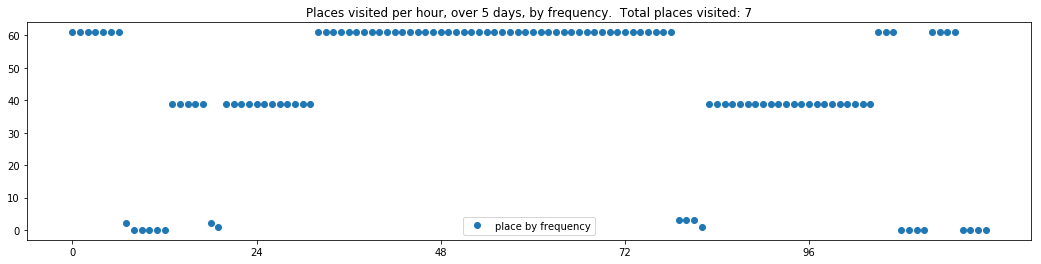

1
----- vector ----
prefix labels:  [7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0]
[0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7]
[7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 7, 9, 0, 7, 7, 0, 0]


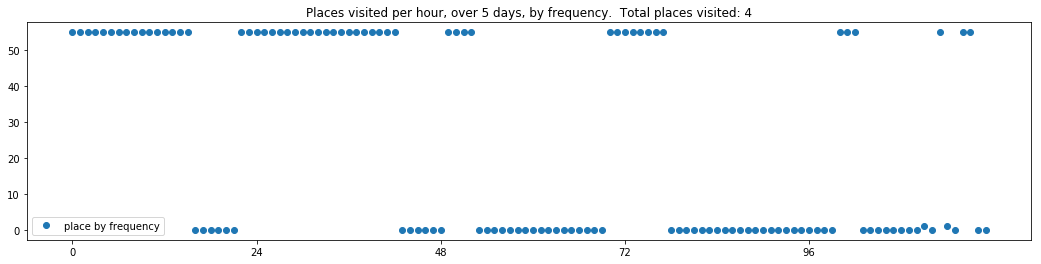

2
----- vector ----
prefix labels:  [10, 12]
[10, 11, 11, 11, 11, 11, 12, 12, 12, 13, 12, 12, 0, 12, 12, 11, 11, 11, 14, 14, 14, 14, 14, 14]
[14, 14, 14, 14, 11, 11, 0, 12, 12, 12, 12, 12, 12, 12, 12, 0, 10, 10, 10, 15, 10, 10, 10, 11]
[11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 12, 12, 11, 11, 11, 11, 0, 16, 17, 17, 17, 17]
[17, 17, 17, 0, 0, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 0, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 11, 11, 12, 12, 13, 12, 13, 18, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10]


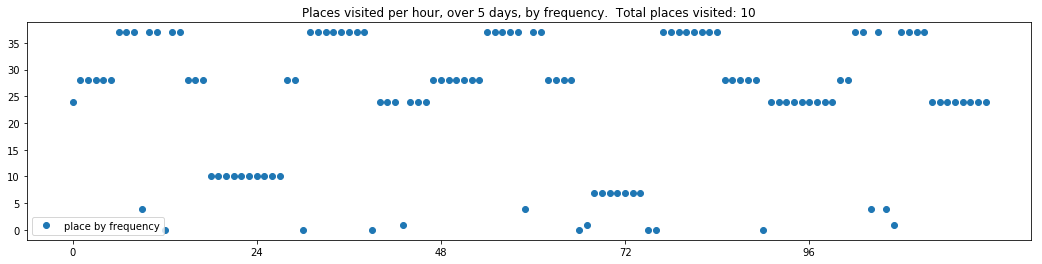

3
----- vector ----
prefix labels:  [19, 19]
[19, 19, 0, 0, 19, 19, 19, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 0]
[0, 0, 0, 0, 0, 0, 0, 19, 21, 21, 21, 21, 21, 21, 21, 0, 0, 19, 19, 19, 19, 19, 19, 22]


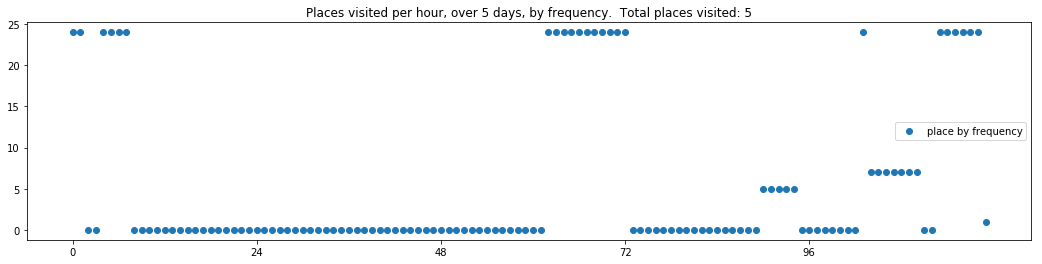

4
----- vector ----
prefix labels:  [23, 24]
[23, 23, 23, 23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 24, 24, 24, 24, 24, 0, 0, 23, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23]
[23, 23, 23, 23, 23, 23, 23, 23, 0, 25, 0, 0, 0, 24, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0]


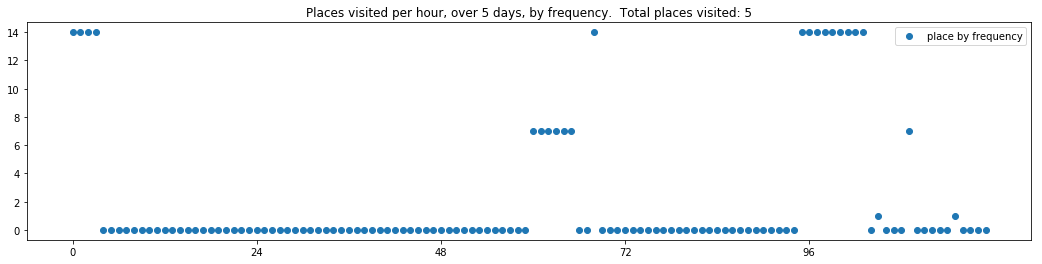

5
----- vector ----
prefix labels:  [27, 27]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0, 0, 20, 20, 27]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 21, 0, 0, 0, 0, 0, 0, 20, 20, 20]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 21, 0, 0, 0, 0, 0, 0, 20, 20, 20]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20]
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 0, 0, 0, 0, 0, 0, 0, 0, 20, 28, 27]


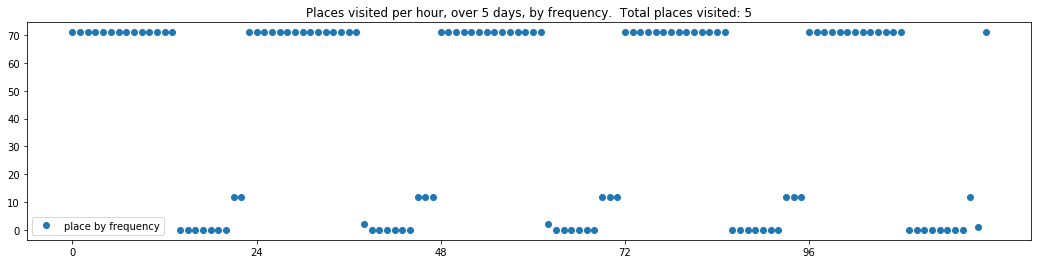

6
----- vector ----
prefix labels:  [29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 31, 31, 32, 32, 29, 0, 0, 33, 29, 29, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 34, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 0, 35, 29, 29, 29, 29, 29, 29, 32, 29, 29, 29]
[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 36, 36, 0, 29, 29, 29, 29, 29, 29, 29, 0, 0, 0, 29]


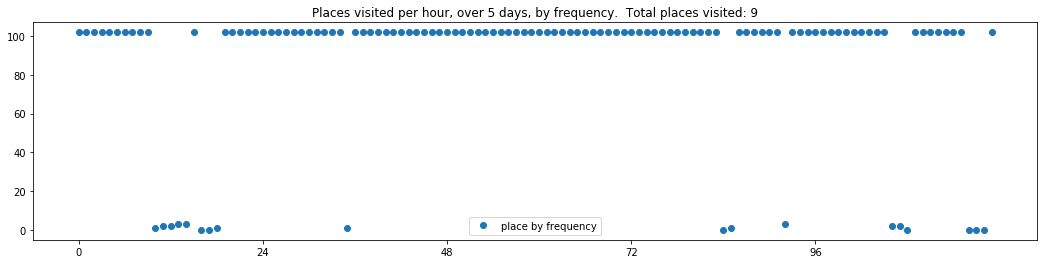

7
----- vector ----
prefix labels:  [37, 38]
[37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 37, 37]
[37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 0, 0, 0, 0, 0, 0, 39, 39, 39, 39]
[0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 0, 0, 0, 0, 38, 38, 38, 38, 38, 38, 38, 37, 37, 37]
[37, 37, 37, 37, 37, 37, 37, 37, 37, 0, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 0, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]


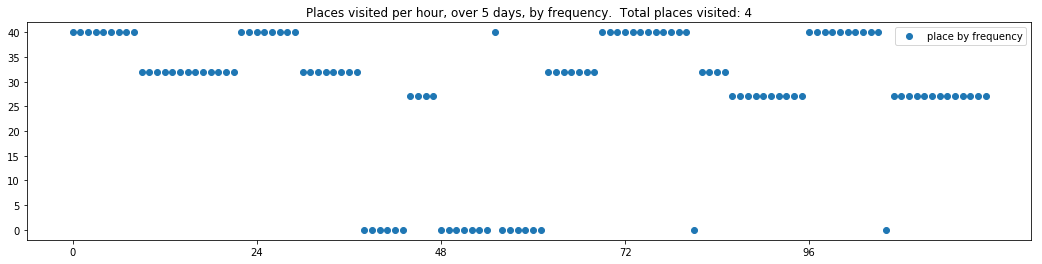

8
----- vector ----
prefix labels:  [41, 41]
[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 20, 20, 20, 20, 20, 20, 40, 40, 40, 40, 40]
[40, 40, 40, 40, 40, 40, 0, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 40, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 40, 40, 0, 0, 40, 40, 41, 41, 0, 42, 41, 41, 41, 41]


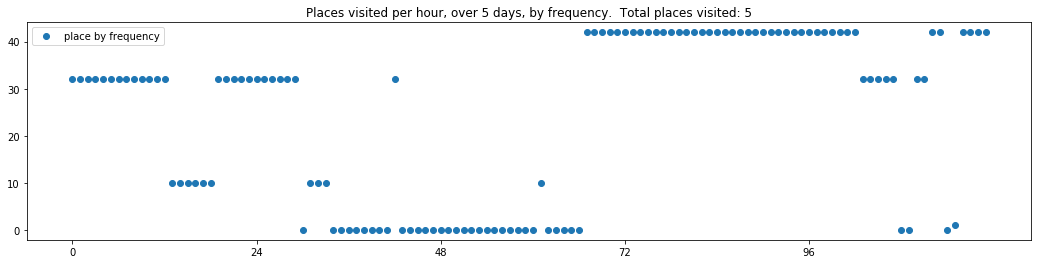

9
----- vector ----
prefix labels:  [43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 0, 0, 43, 43, 43, 43, 0, 0, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 43, 43]
[43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 0, 0, 0, 0, 0]


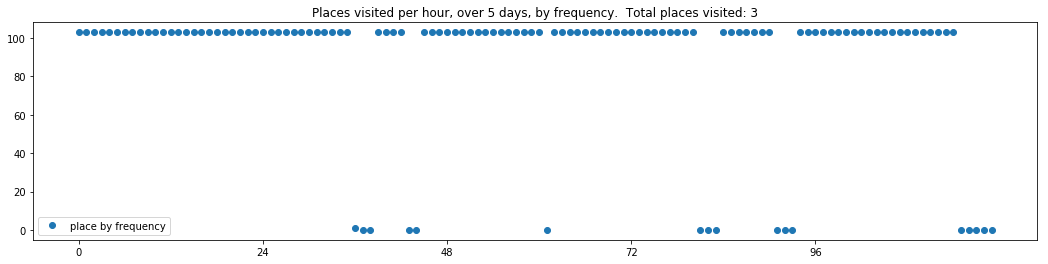

10
----- vector ----
prefix labels:  [45, 45]
[45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0]
[0, 45, 45, 45, 45, 45, 45, 0, 0, 0, 45, 0, 0, 0, 0, 0, 0, 0, 45, 0, 0, 47, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 0, 0, 45, 45, 45, 0, 0, 0, 45, 0, 0]


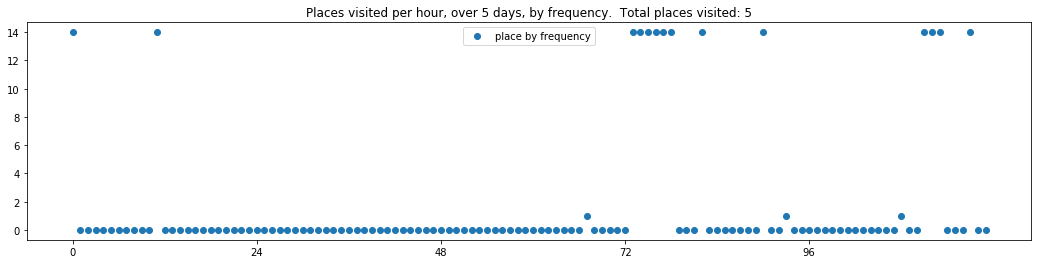

11
----- vector ----
prefix labels:  [49, 49]
[20, 0, 20, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 20, 50, 50, 51, 0, 20, 0, 0, 0]
[20, 0, 0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 20, 20, 0, 52, 0, 22, 20, 53, 20]
[20, 0, 49, 49, 0, 0, 0, 0, 0, 0, 49, 49, 49, 20, 0, 54, 0, 0, 49, 20, 0, 0, 0, 55]
[20, 0, 0, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 56, 0, 57, 22, 20, 0, 0]
[0, 20, 20, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 58, 59, 59, 0, 58, 58, 49, 49, 20, 0, 20]


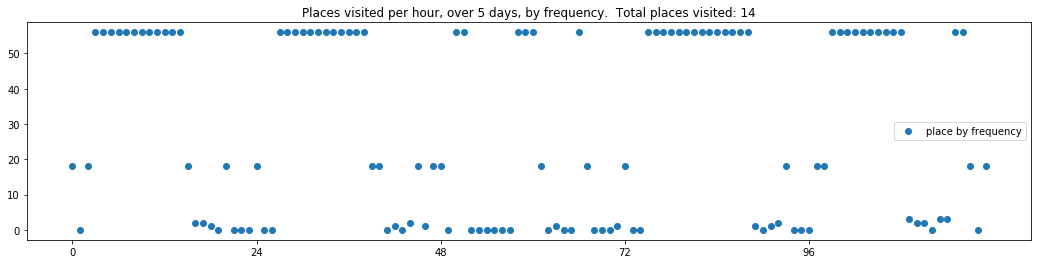

12
----- vector ----
prefix labels:  [60, 0]
[60, 60, 0, 0, 60, 60, 0, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 62, 62, 62, 62, 62, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60, 60]
[60, 60, 60, 60, 60, 60, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60]
[60, 60, 60, 60, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 60]


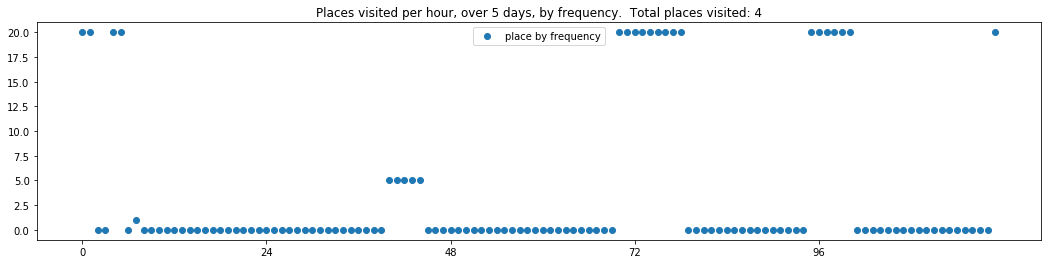

13
----- vector ----
prefix labels:  [64, 65]
[63, 63, 0, 0, 0, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64, 64, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 66, 65, 65, 65, 65, 65, 65, 31, 31, 67, 31, 31, 64, 64, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 64, 0, 65, 65, 65, 65, 65, 66, 64, 64, 64, 64, 68, 64, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 69, 31, 31, 64, 64]
[64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 31, 31, 31, 0, 0, 66, 66, 64, 64, 64, 64, 64]


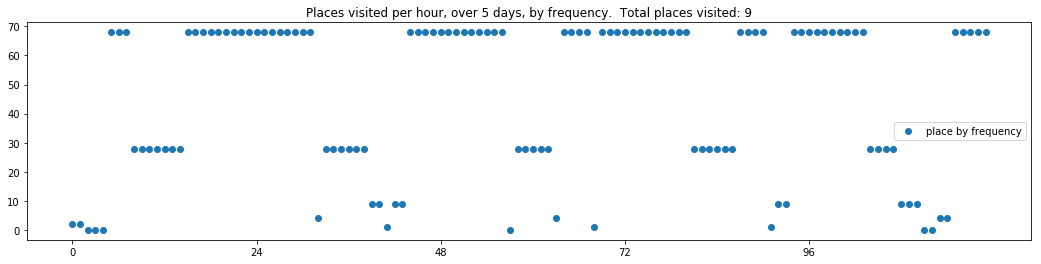

14
----- vector ----
prefix labels:  [70, 71]
[70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 70, 70, 70, 70, 70, 70, 70, 70]
[0, 70, 70, 70, 70, 70, 70, 71, 71, 71, 0, 0, 0, 0, 70, 70, 70, 70, 70, 70, 70, 70, 70, 21]
[70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 72, 70, 70, 70, 70, 70, 70, 70, 70]
[70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 0, 70, 70, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 70, 0, 0, 0, 0, 0, 0, 0]


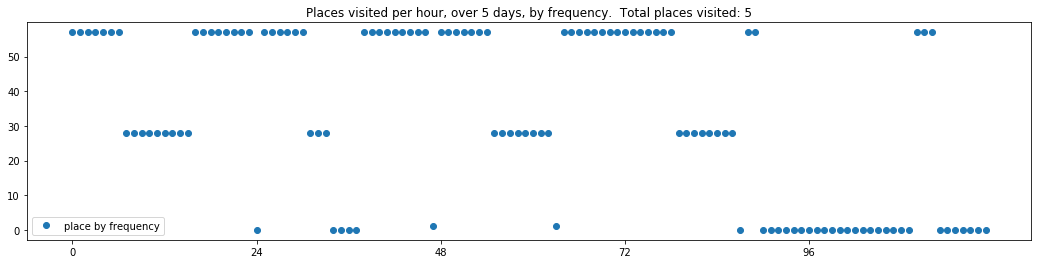

15
----- vector ----
prefix labels:  [15, 73]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 73, 73, 73, 73, 73, 73, 73, 15, 15, 15, 15, 15, 15, 15]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 0, 15, 73, 73, 73, 73, 73, 73, 73, 73, 73]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 73, 73, 73, 73, 73, 73, 73, 73, 73, 15, 0, 15, 15, 52, 52]
[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 74, 74, 8, 8, 21, 21, 21, 21, 52, 52, 52, 15]
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 0, 0, 0, 0, 0, 0, 0, 0]


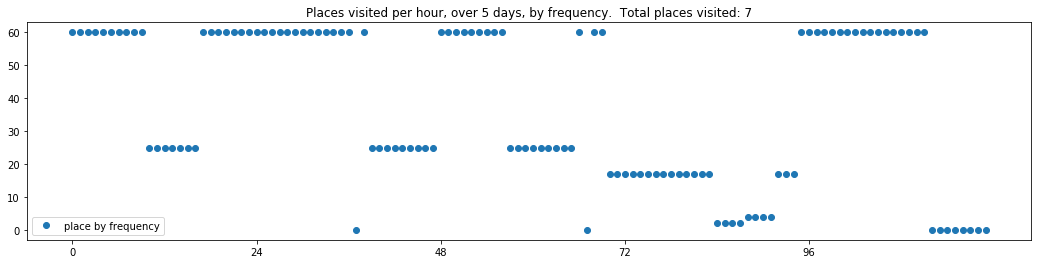

16
----- vector ----
prefix labels:  [75, 75]
[75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 0, 0, 77, 77, 77, 77, 77, 75, 75, 75, 75, 75, 75]
[75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 75, 75, 75, 75, 75, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 75]
[75, 75, 75, 75, 75, 75, 75, 75, 75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75]


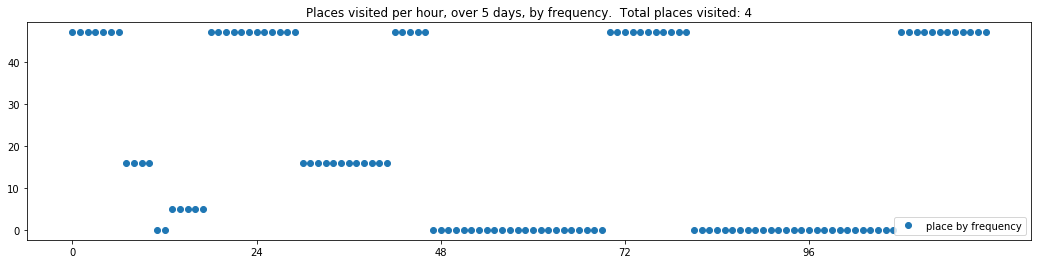

17
----- vector ----
prefix labels:  [78, 31]
[78, 78, 78, 78, 31, 79, 79, 80, 81, 31, 31, 13, 13, 34, 82, 83, 3, 31, 31, 78, 78, 20, 84, 78]
[78, 78, 78, 78, 31, 31, 31, 80, 82, 31, 31, 31, 31, 31, 35, 83, 0, 0, 0, 0, 78, 20, 84, 78]
[78, 78, 0, 78, 31, 31, 83, 83, 82, 31, 31, 31, 31, 31, 31, 85, 31, 31, 78, 78, 20, 20, 84, 78]
[78, 78, 78, 0, 0, 0, 80, 80, 82, 31, 31, 31, 31, 31, 82, 80, 35, 86, 78, 78, 20, 20, 84, 78]
[78, 78, 78, 78, 31, 31, 31, 80, 82, 31, 31, 31, 31, 31, 81, 80, 3, 85, 85, 78, 20, 53, 78, 78]


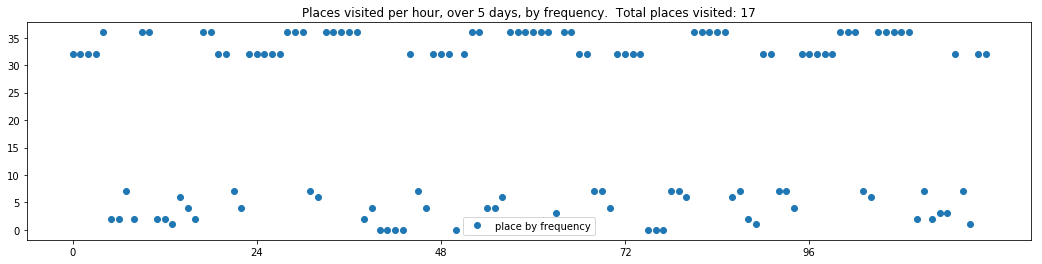

18
----- vector ----
prefix labels:  [87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 88, 89, 89, 89, 89, 89, 89, 89, 0, 89, 89, 0, 90, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 89, 0, 0, 0, 89, 89, 89, 89, 0, 0, 0, 87, 87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 91, 87, 87, 87, 87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 89, 89, 89, 87, 87, 87, 87, 87, 87, 87, 87, 0, 0, 0, 87, 87]
[87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 92, 0, 87, 87, 87, 0, 0, 0, 0, 0, 0]


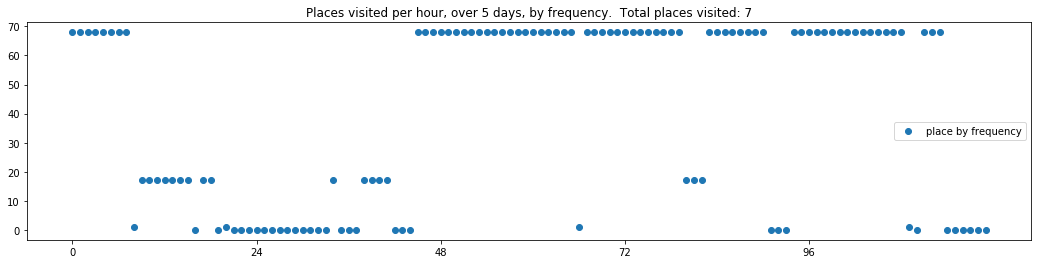

19
----- vector ----
prefix labels:  [93, 94]
[93, 93, 93, 93, 93, 93, 93, 93, 0, 0, 0, 0, 0, 0, 0, 94, 0, 93, 93, 93, 93, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 93, 93, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 94, 94, 94, 94, 94, 0, 0, 95, 0, 0, 0, 0, 0, 93]
[93, 93, 93, 93, 93, 93, 93, 93, 0, 0, 94, 94, 94, 94, 94, 94, 94, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4]


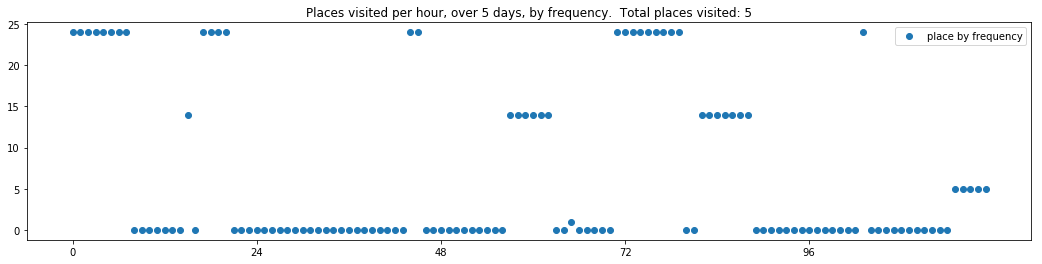

In [11]:
for t, tv in enumerate(real_trajectories[:sample_size]):
    print(t)
    print_dwell_vector_by_days(tv)
    plot_trajectory_vector_frequencies(tv, by_frequency_order=False)

Load and inspect trajectories generated by the textgenrnn model

In [12]:
# For these trajectories, we generated trajectories for each of the cambridge census tract areas as home labels.
# When comparing the real and generated output, only data with these home labels should be considered.

textgenrnn_cambridge_trajectories_08_filename = '../textgenrnn_generator/output/generated_trajectories_1_week_cambridge_temp_0.8.txt'
textgenrnn_cambridge_trajectories_09_filename = '../textgenrnn_generator/output/generated_trajectories_1_week_cambridge_temp_0.9.txt'
textgenrnn_cambridge_trajectories_1_filename = '../textgenrnn_generator/output/generated_trajectories_1_week_cambridge_temp_1.0.txt'

textgenrnn_cambridge_trajectories_set = {
    0.8: read_trajectories_from_file(textgenrnn_cambridge_trajectories_08_filename),
    0.9: read_trajectories_from_file(textgenrnn_cambridge_trajectories_09_filename),
    1.0: read_trajectories_from_file(textgenrnn_cambridge_trajectories_1_filename),
}

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


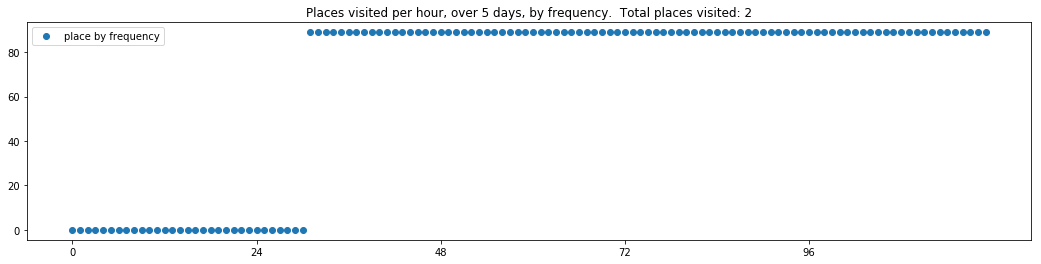

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 401, 401, 401, 401, 401, 401, 401, 401, 401]
[401, 401, 401, 401, 401, 401, 401, 0, 401, 401, 401, 248, 248, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401]
[401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401]


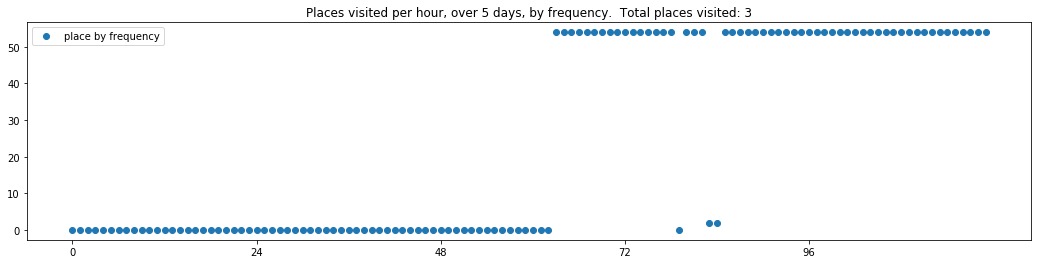

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 0, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 386, 386, 386, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 386, 386, 386, 386]
[386, 386, 386, 386, 386, 386, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 386, 386, 386, 386]


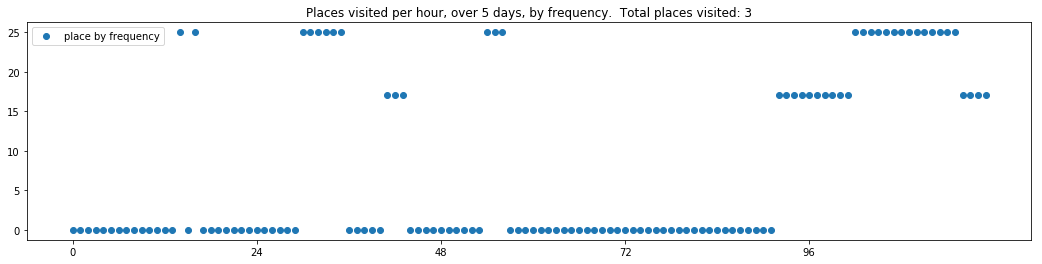

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


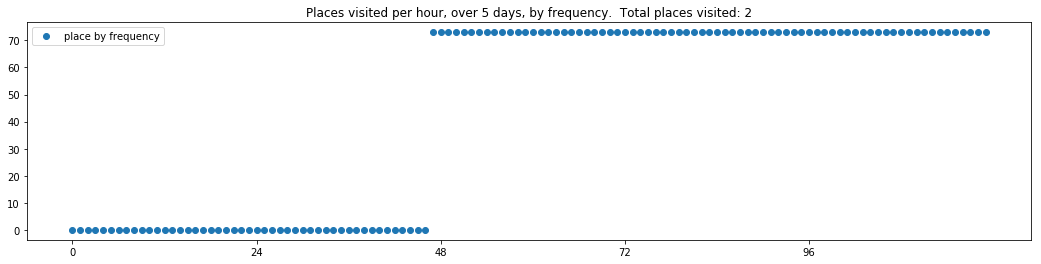

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59, 10, 10, 0, 0, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 495, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


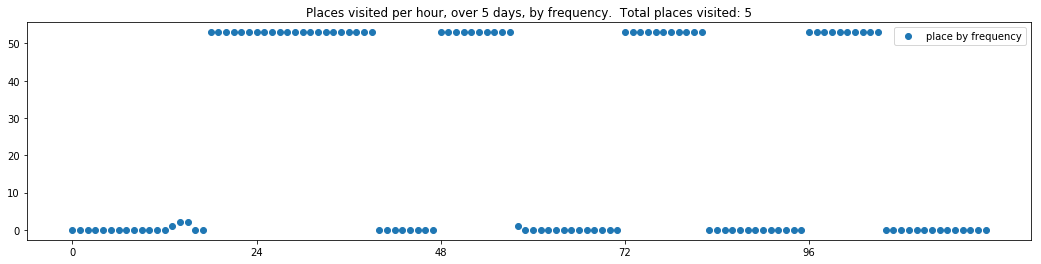

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558]
[558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558]


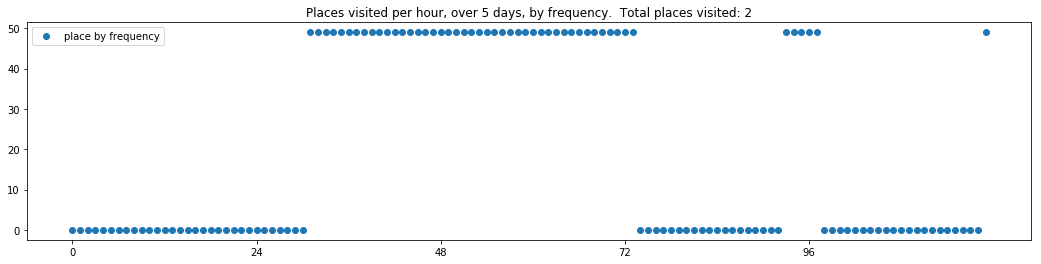

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


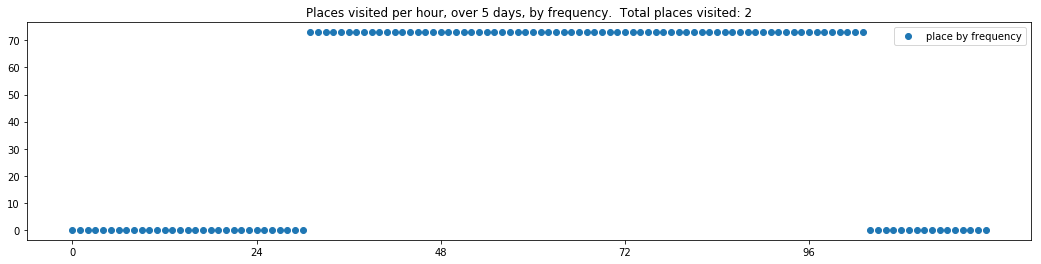

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


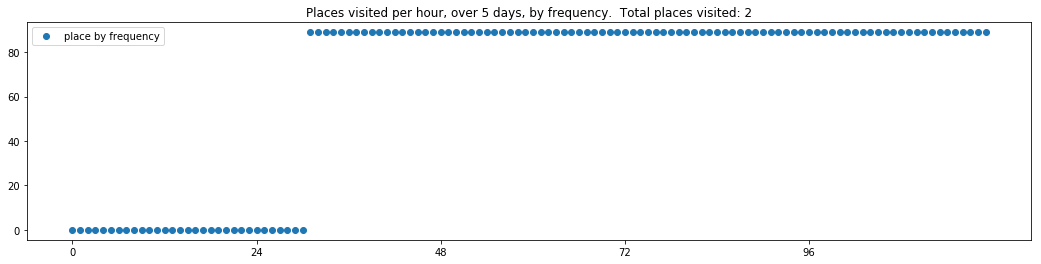

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


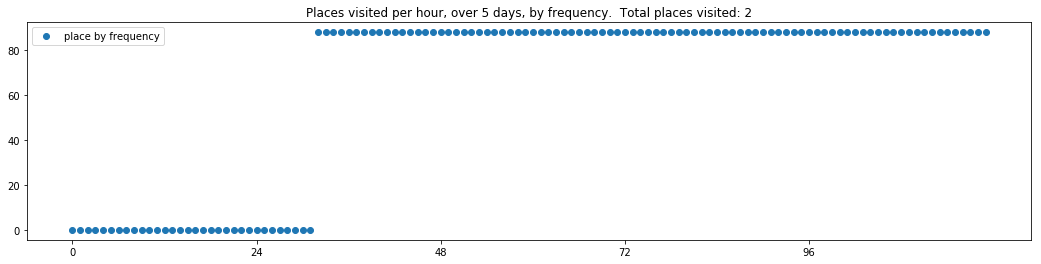

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 193, 461, 461, 461, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 558, 558, 450, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


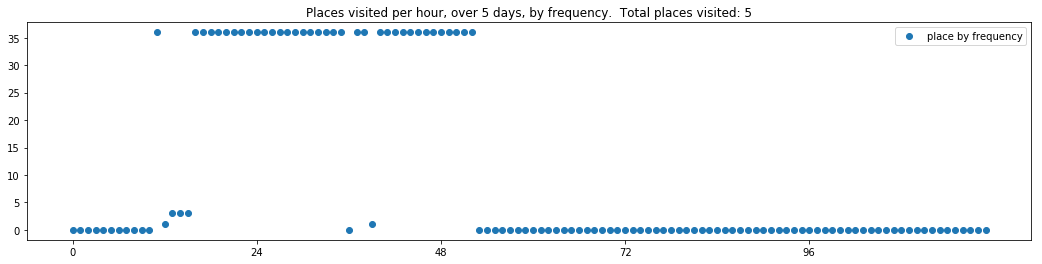

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


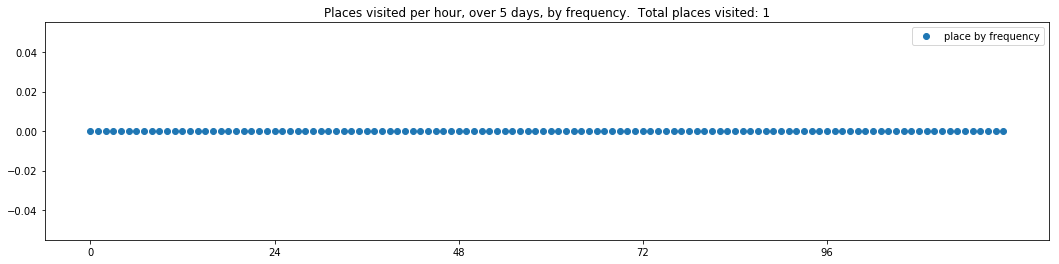

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


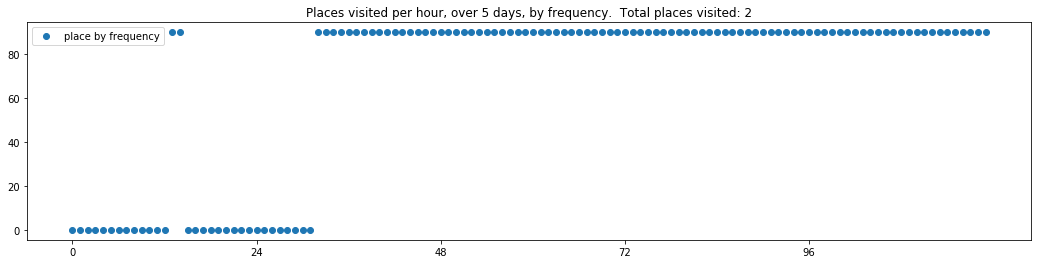

----- vector ----
prefix labels:  [558, 558]
[0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


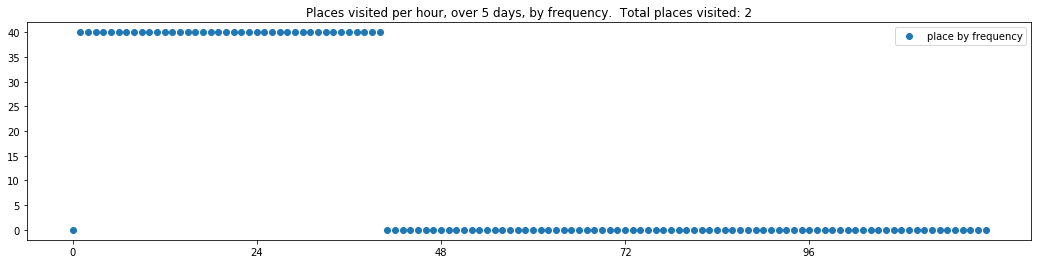

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 214]


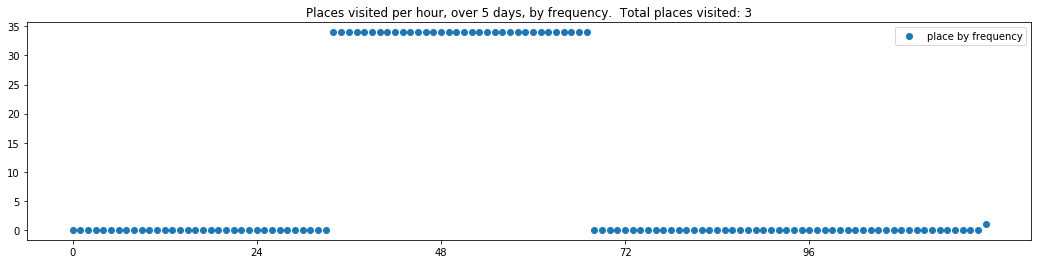

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 171, 171, 495, 558, 0, 373, 373, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 373, 373, 558, 558, 558, 558, 2, 2, 0, 0, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 2, 2, 2, 2]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0]


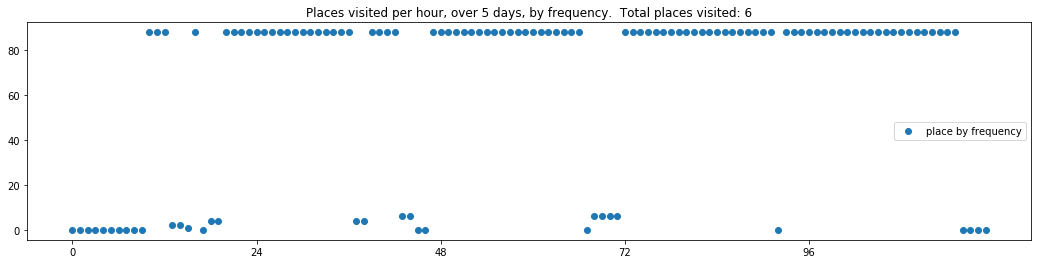

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 247, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 247, 0, 0, 0, 0, 0]


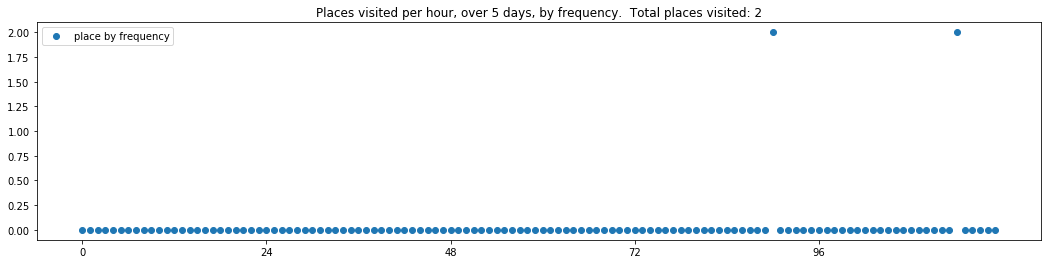

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0]


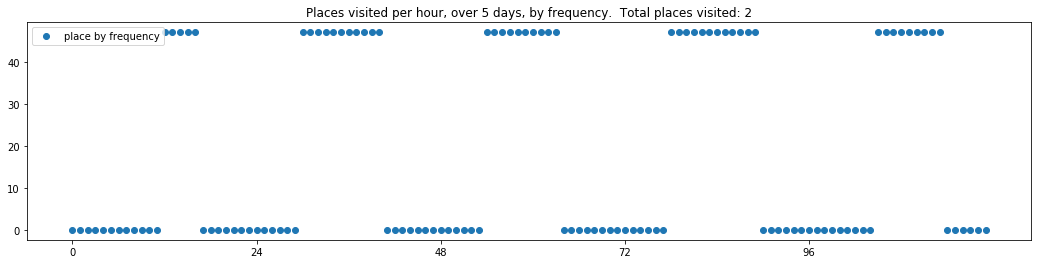

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


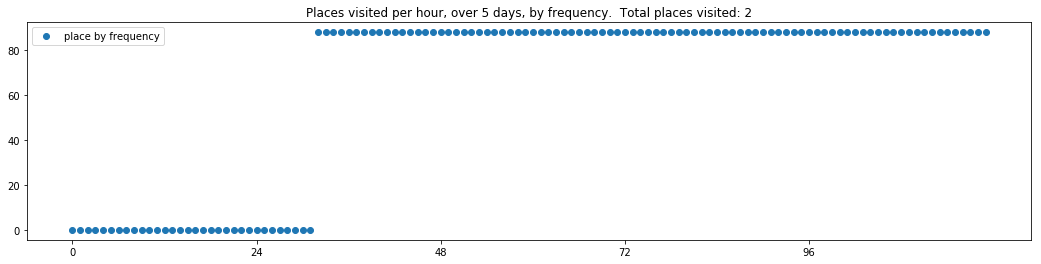

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 21, 21, 21, 21, 21, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 21, 21, 21, 21, 21, 21, 212, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 21, 21, 21, 21, 21, 21, 21, 21, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 21, 21, 21, 21, 21, 21, 21, 21, 21, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 485, 558, 558, 558, 558, 558, 184, 184, 184, 184, 184, 184, 558, 558]


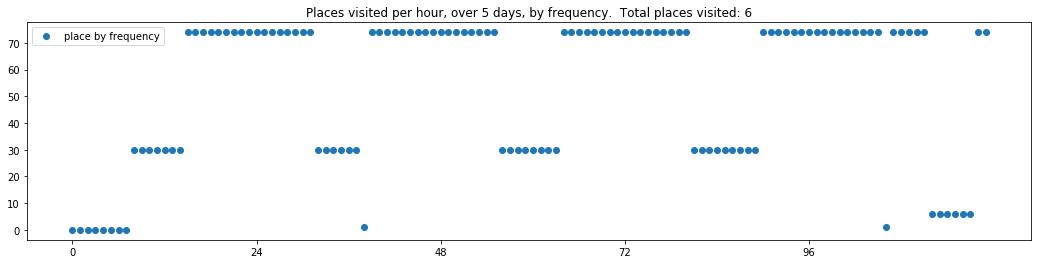

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 456, 0, 456]
[0, 0, 0, 0, 0, 0, 248, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 456, 456, 456, 0, 456]
[456, 456, 0, 456, 456, 535, 535, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 456, 456, 456, 456, 456]
[456, 456, 456, 456, 456, 456, 456, 456, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 456, 456, 456, 456, 456]
[456, 456, 456, 456, 456, 456, 456, 401, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 456, 456, 456, 456, 456, 456]


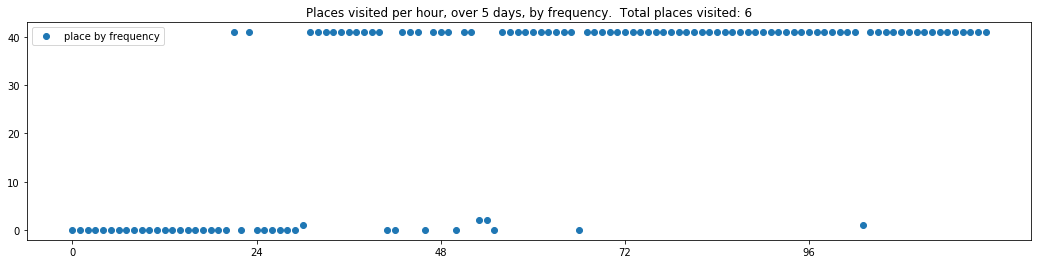

In [13]:
for tv in textgenrnn_cambridge_trajectories_set[0.8][:sample_size]:
    print_dwell_vector_by_days(tv)
    plot_trajectory_vector_frequencies(tv, by_frequency_order=False) 

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 8, 8, 21, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 450, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 267, 212, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 0, 0, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 558, 558, 558, 558, 558, 558, 558, 558, 558]


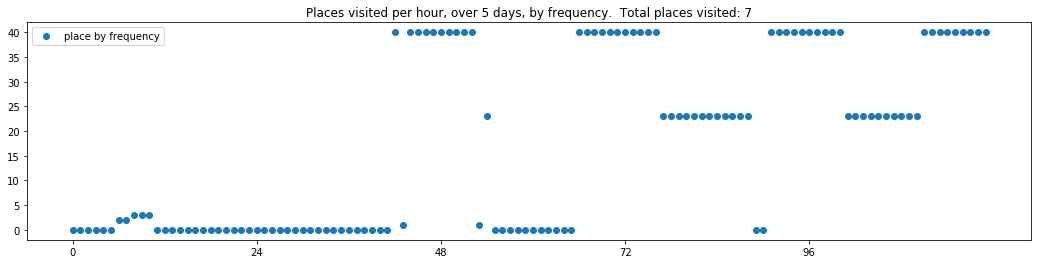

----- vector ----
prefix labels:  [558, 558]
[0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 558, 558, 0, 558, 558, 558, 558, 0, 0, 57]
[57, 57, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 558, 0, 558, 558, 0, 0, 0]
[0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 20, 20, 20, 0, 0, 0, 0, 637]
[637, 637, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


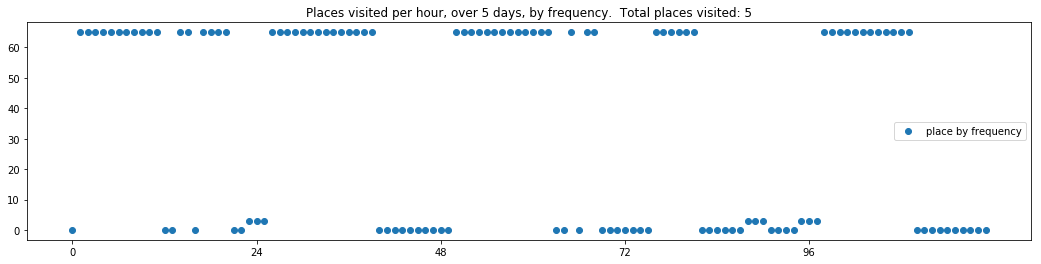

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 204, 204, 204, 151, 558, 558, 558, 558, 558, 448, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 497, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 0, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]


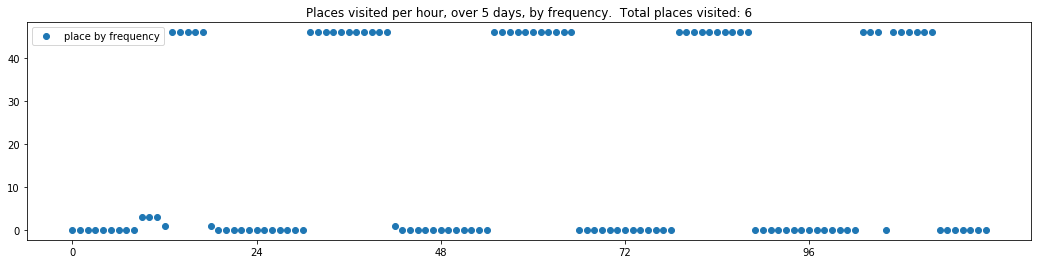

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


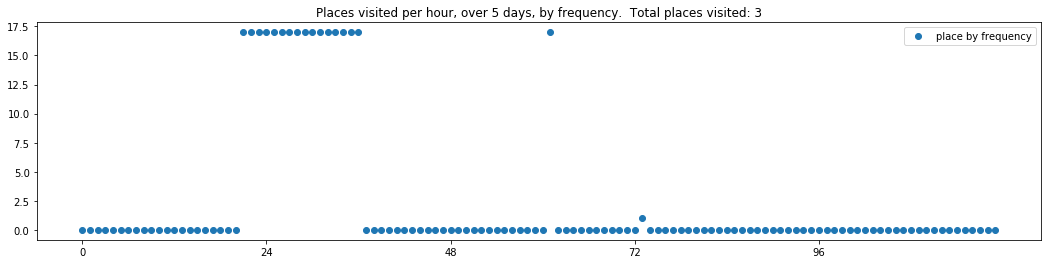

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 0, 0, 0, 558, 558, 558, 558, 132, 132, 373, 373, 373, 373, 373, 373]
[373, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 464, 464, 558, 558, 558, 0, 450, 450, 450, 450, 450, 0, 0]
[0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 558, 558, 637, 637, 558, 558, 558, 558, 450, 566, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 558, 473, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0]


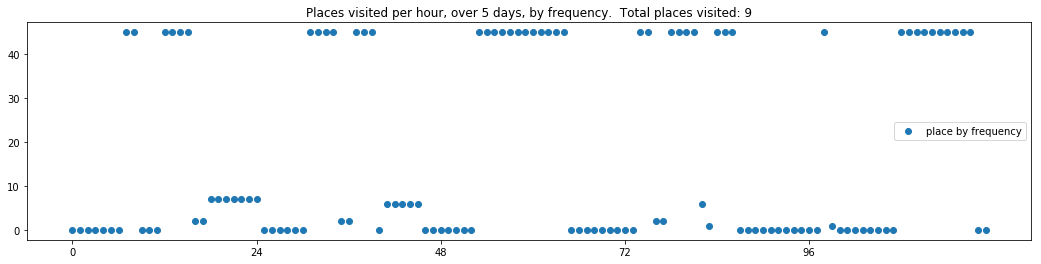

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 21, 21, 21, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 55, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 55, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


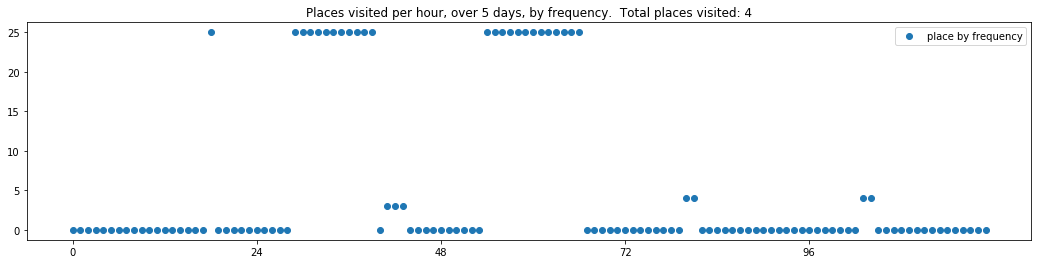

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 298, 298, 0, 0, 0, 0, 0, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 261, 373, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 97, 0, 473, 21, 97, 0, 0, 394, 495, 495, 495, 495, 0, 0, 0, 0, 0]
[558, 558, 558, 558, 558, 482, 558, 558, 558, 558, 558, 558, 228, 452, 452, 0, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 50, 50, 0, 0, 0, 495, 495, 495, 495, 495, 495, 558, 558, 558, 558]


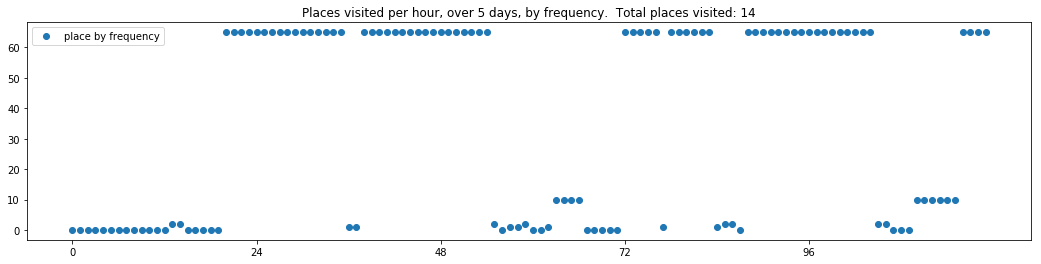

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 0, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 0, 0, 0, 0, 558, 558, 558, 0, 0, 0, 341, 341, 341, 0, 0]
[0, 0, 0, 341, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 0, 522, 0, 0, 0, 0, 341, 341]
[341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 0, 0, 0, 0, 0, 0, 0, 341, 0]


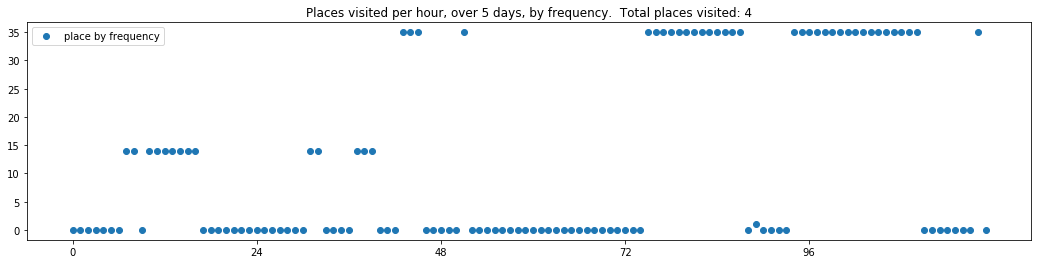

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 558, 450, 450, 450, 450, 450, 450, 450, 450, 558, 558, 558, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 119, 119, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 119, 0, 0, 450, 450, 450, 450, 450, 450, 450, 450, 450, 119, 119, 119, 119, 119, 119, 119]
[119, 119, 119, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 315, 315, 315, 0]
[119, 119, 119, 227, 119, 267, 267, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


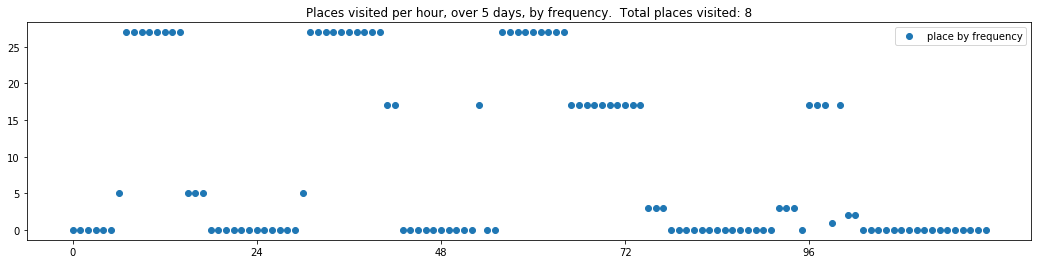

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 145, 576, 576, 576, 85, 0, 0]
[0, 0, 0, 0, 576, 576, 576, 576, 576, 576, 558, 558, 558, 558, 558, 558, 558, 558, 0, 576, 576, 85, 85, 0]


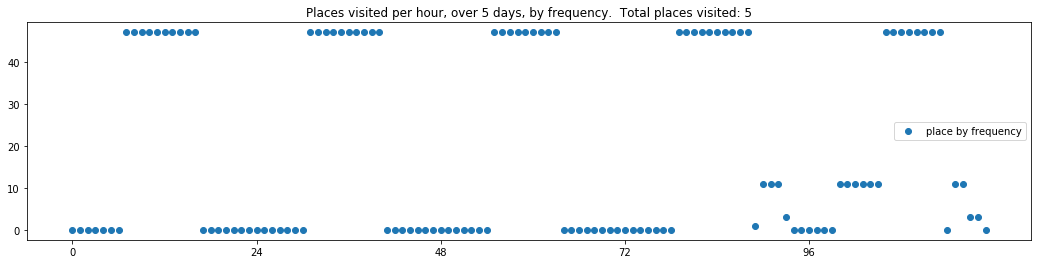

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 183, 183, 0, 0, 0]
[0, 0, 0, 0, 0, 558, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 151, 151, 78, 78, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


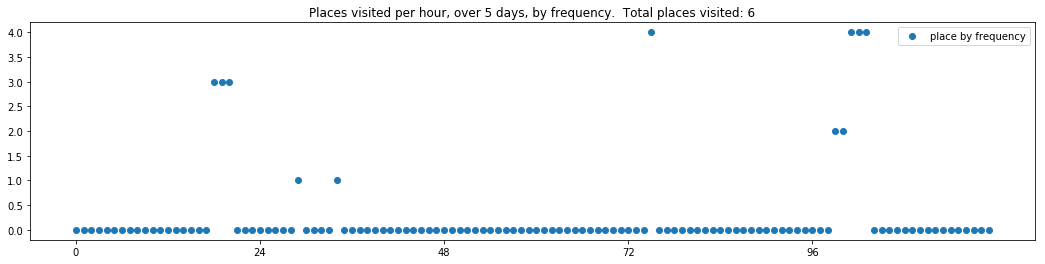

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 447, 447, 183, 183, 184, 184, 184, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 373, 373, 261, 558, 564, 57, 326, 326, 450, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 603, 485, 349, 558, 183, 183, 21, 21, 21, 430, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 274, 558, 558, 558, 558, 558, 558, 495, 495, 644]
[644, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 430, 558, 558, 558, 558, 558, 558, 430, 430, 495, 644]


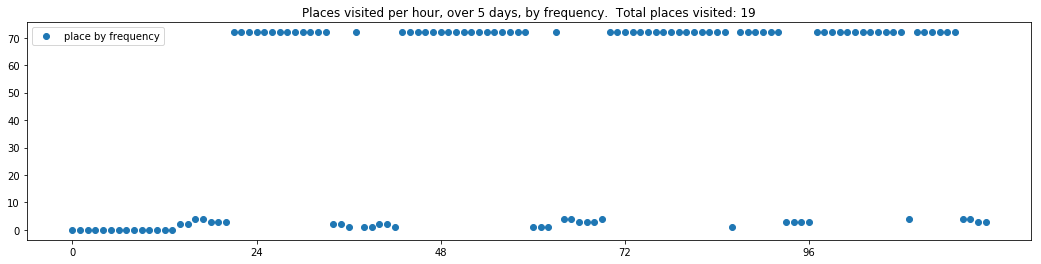

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 0, 0, 558, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 33, 33, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558]
[558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 0, 0, 558, 558, 558, 558]


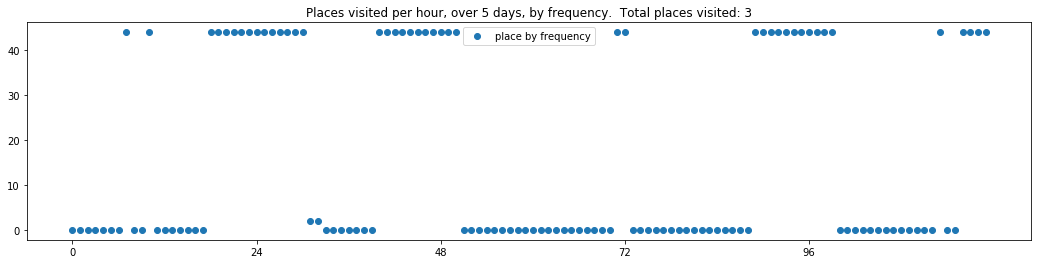

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 450, 0, 0, 0, 0, 0, 0, 558, 88, 0, 4, 0, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 0, 450, 450, 450, 0, 0, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 558, 0, 0, 0, 450, 450, 171, 171, 260, 0, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 450, 450, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0]


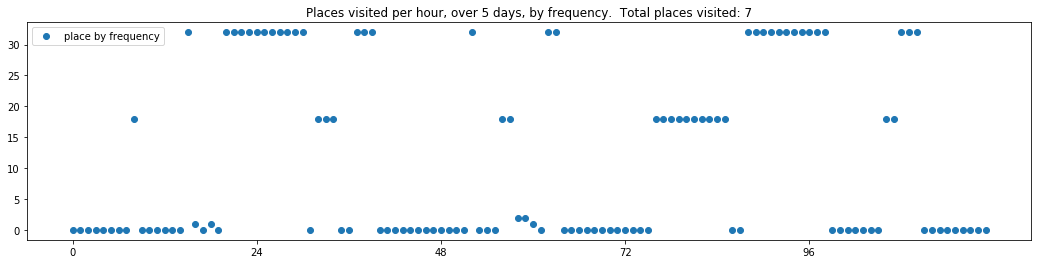

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 287, 287, 287, 558, 558, 287, 287, 287]
[287, 287, 287, 287, 287, 287, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[287, 287, 287, 287, 287, 287, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 287, 287, 287, 287, 287]
[287, 287, 287, 287, 287, 287, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 0, 0, 0, 0, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287]


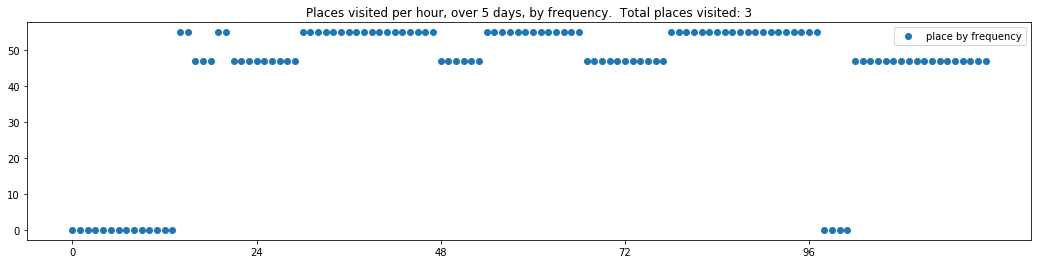

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 323, 323, 558, 76, 76, 558, 558, 373, 558, 558, 558, 267, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 464, 558, 558, 558, 373, 50, 558, 558, 0, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 74, 74, 100, 0, 235, 267, 386, 133, 558, 558, 558, 558, 450, 450, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 267, 267, 485, 485, 221, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 267, 267, 373, 373, 373, 373, 373, 373, 558, 558, 558, 558, 558, 558, 56, 56, 56, 56, 56, 56, 386]


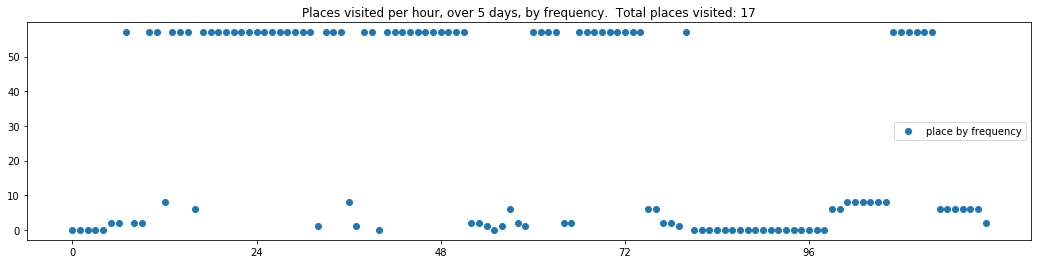

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 0, 0, 558, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 130, 130, 130, 130]


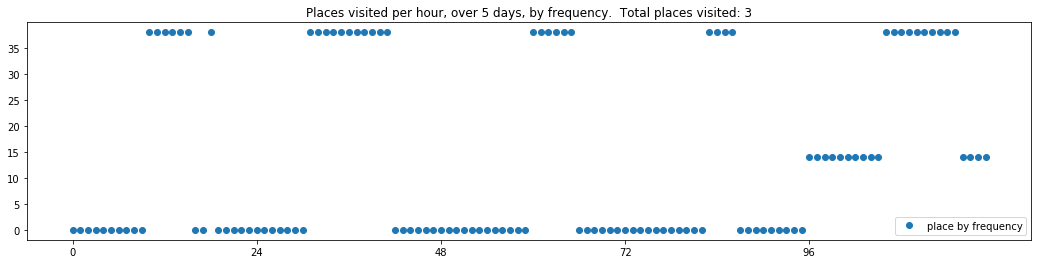

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 430, 326, 558, 558, 558, 558, 558, 430, 382, 276, 558, 450, 450, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 271, 271, 271, 271, 271, 22, 22, 22, 450, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 271, 271, 22, 22, 22, 22, 22, 22, 22, 162, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 349, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 396, 177, 329, 20, 0, 0, 22, 22, 22, 329, 558, 558, 558, 558]


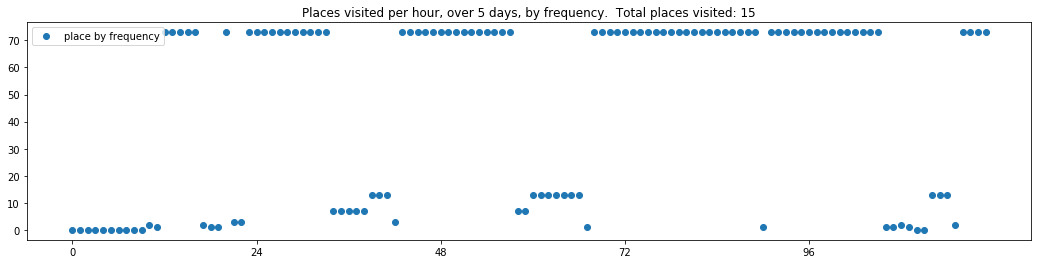

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 374, 42, 558, 558, 558, 558, 558, 558, 321, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 545, 545, 545, 369, 464, 558, 558, 0, 0, 0, 0]
[0, 0, 485, 373, 545, 0, 0, 0, 0, 0, 0, 0, 299, 299, 558, 558, 15, 15, 15, 15, 15, 15, 15, 15]
[15, 0, 0, 94, 94, 94, 0, 0, 0, 0, 0, 0, 373, 373, 573, 573, 261, 261, 0, 0, 0, 0, 0, 15]
[15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 15, 15, 15, 15, 15, 334]


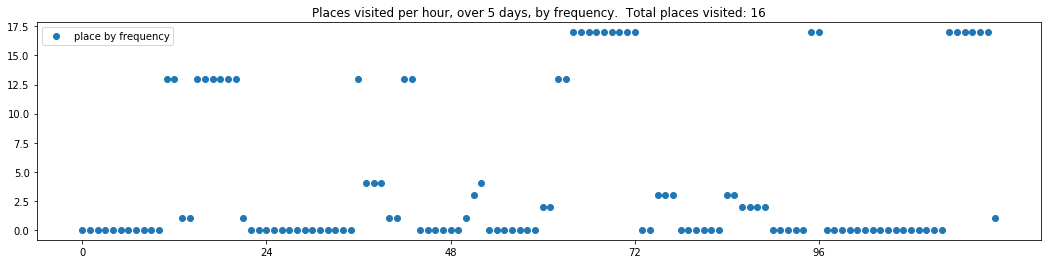

----- vector ----
prefix labels:  [558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 558, 558, 558, 558]
[558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 410, 0, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 69, 185, 171, 558, 558, 0, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 541, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 485, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 541, 541, 541, 0, 0, 0, 0, 541, 541, 20, 0, 541]


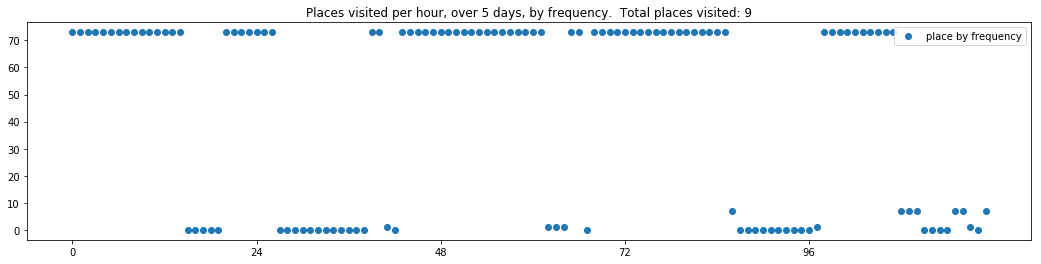

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 183, 183, 183, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 183, 183, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 0, 183, 183, 183, 183, 183, 183, 183, 183, 0, 0, 0, 0, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 386, 386, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


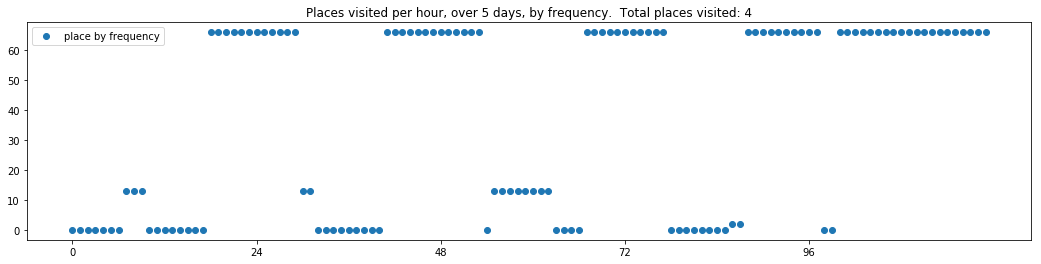

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 385, 20, 0, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0]
[20, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 558, 558, 558, 558, 558, 558]


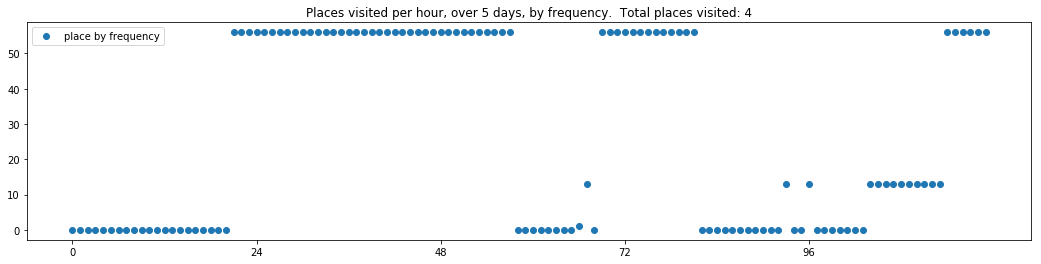

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 558, 0, 558, 0, 0, 0, 0, 0, 558, 0, 0, 558, 76, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 474, 0, 0, 0, 330, 330, 330, 558, 558, 558, 558, 558, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 290, 290, 290, 290, 290, 644, 290, 290, 0, 0, 288, 288, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 450, 450, 498, 498, 558, 558]
[558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 290, 290, 290, 290, 558, 0, 0, 0, 0, 0]


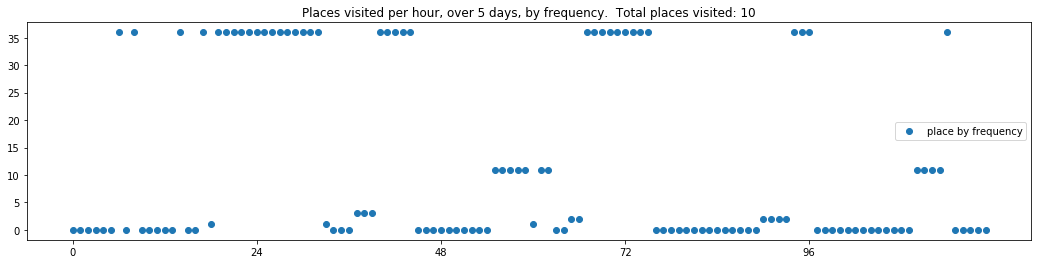

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 236, 236, 236, 236, 558, 558, 236, 236, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 236, 236, 236, 236, 236, 236, 236, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 236, 236, 236, 236, 0, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 545, 545, 545, 373, 236, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 76, 76, 76, 76, 76, 374, 386, 386, 573, 0, 0, 0, 0, 0]


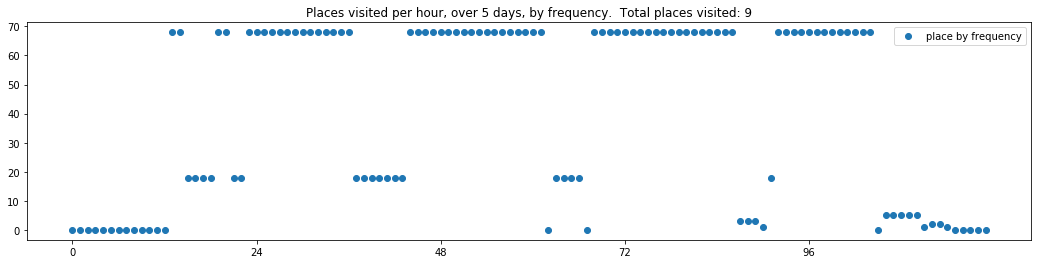

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0]
[0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 450, 373, 373, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 10, 10, 10, 10, 10, 558, 558, 558, 558, 558]


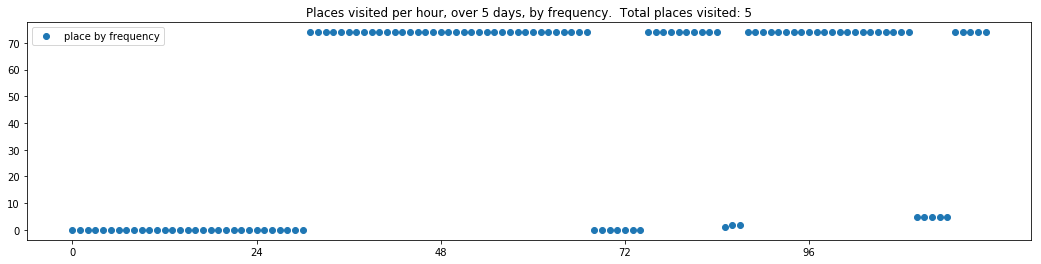

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 346, 132, 132, 132, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 4, 4, 4, 4, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 558, 558, 558]
[0, 0, 0, 0, 0, 317, 317, 317, 317, 317, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 0, 0, 0, 558, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0]


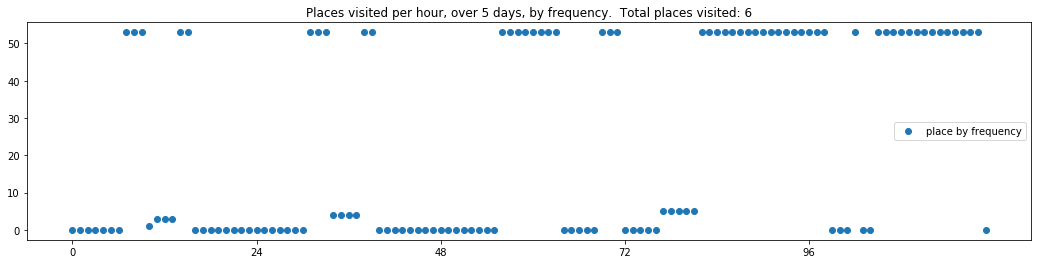

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 558, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


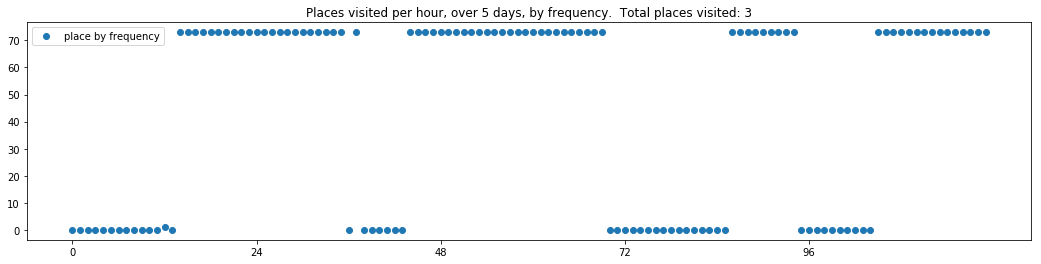

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 364, 364, 364, 0, 100, 100, 552, 21, 21, 21, 21, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558]
[558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 0, 0, 0, 0, 0, 0, 0]


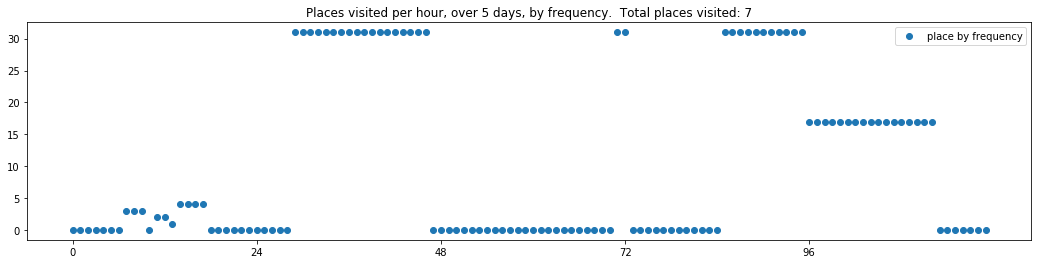

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]


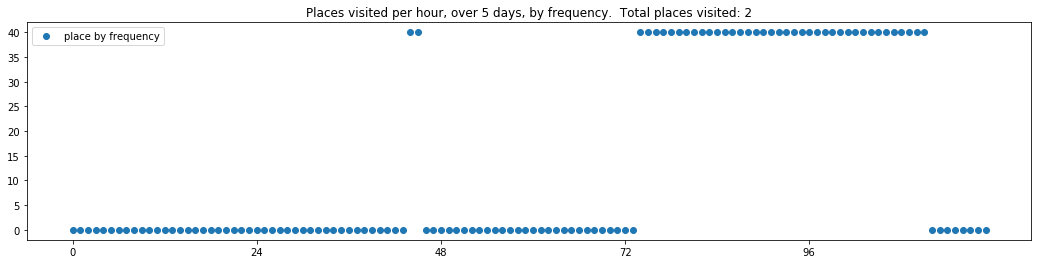

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 574, 558, 558, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 274, 0, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 558, 558, 558]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 157, 432, 24, 24, 0, 558, 558, 558]


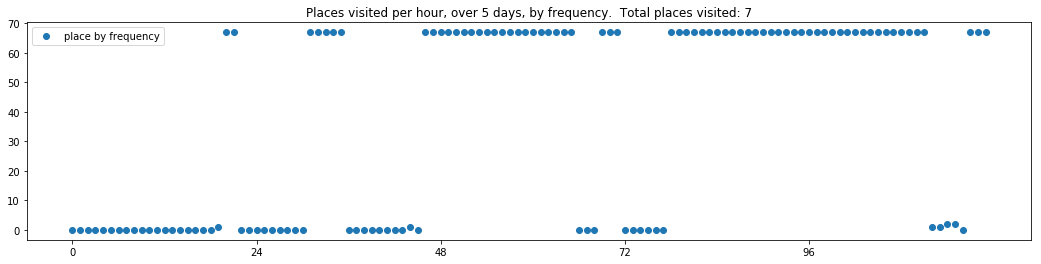

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 143, 143, 143, 143, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 430, 430, 430, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 430, 430, 430, 430, 430]
[430, 430, 430, 430, 430, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 430, 430, 430, 430, 430]
[430, 430, 430, 430, 430, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 430, 430, 430, 430]


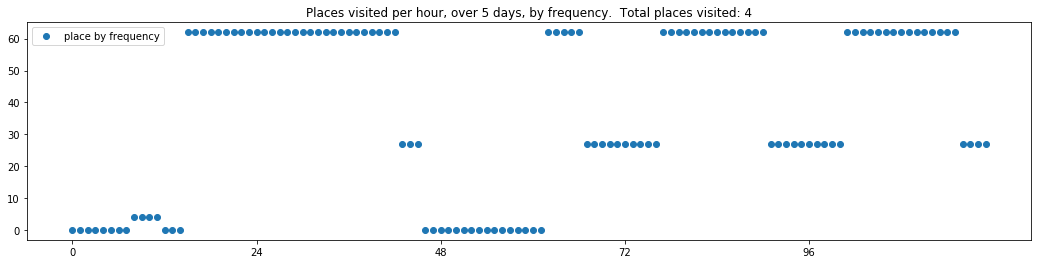

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 90, 90, 0, 0, 0, 0, 0, 0, 84, 84, 84, 84, 84, 20, 274, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 84, 84, 84, 84, 84, 84, 84]
[84, 84, 458, 0, 0, 0, 90, 0, 122, 0, 0, 0, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]


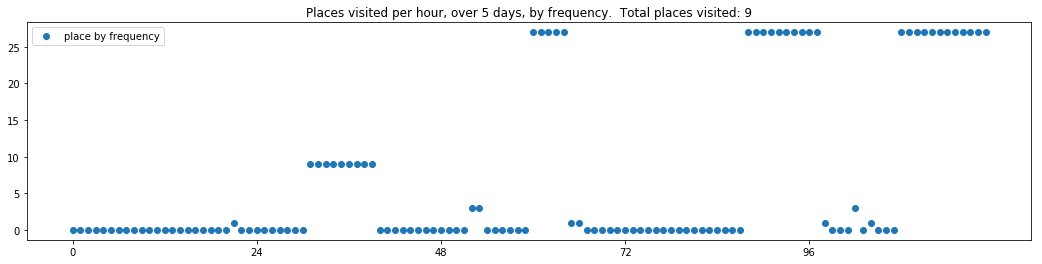

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 236, 236, 558, 558, 0, 0, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 558, 558, 558, 558, 184, 0, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 20, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


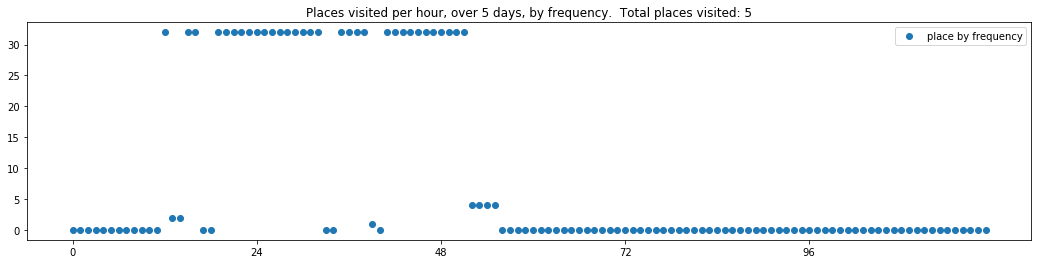

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]


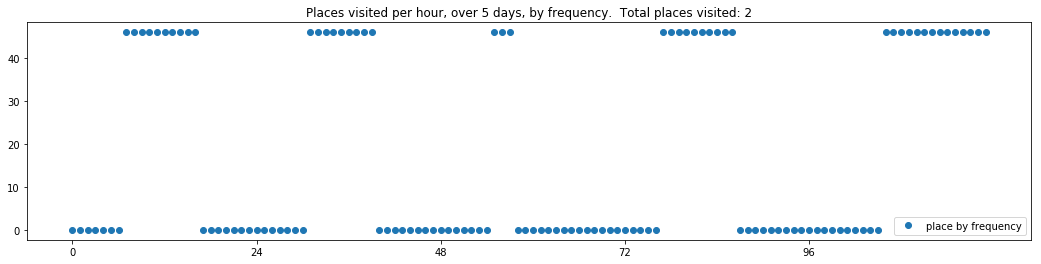

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 0, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558]
[558, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558]


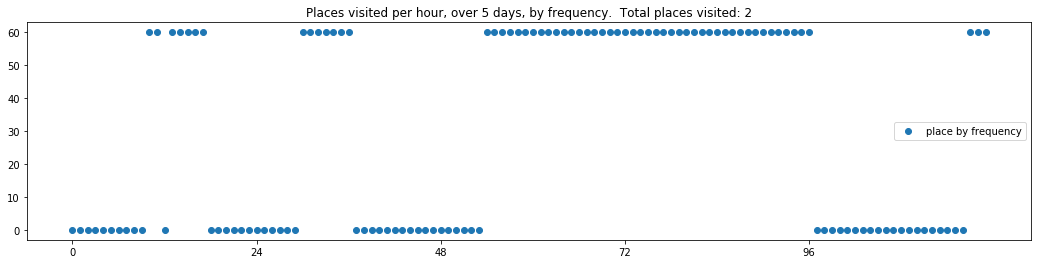

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 571, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 2, 2, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 337, 218, 218, 218, 0, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0]


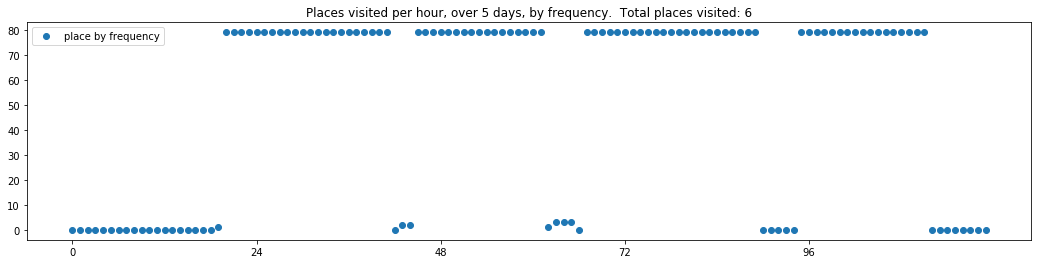

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 450, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 0, 450, 545, 545, 0, 0, 450, 450, 0, 558, 558, 558, 558, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 558, 450, 450, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 0, 0, 558, 558, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 450, 450, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0]


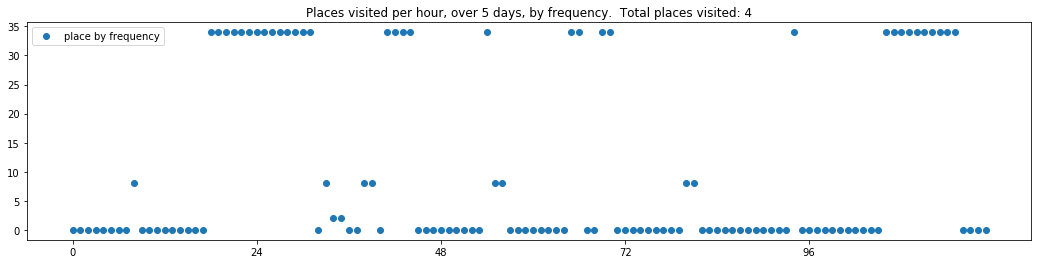

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 323, 495, 495, 495, 495, 603, 386, 386, 386, 386, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 162, 302, 495, 495, 495, 495, 495, 495, 495, 495, 558, 558]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 495, 495, 545, 545, 545, 162, 334, 334, 545, 545, 119, 450]
[558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 519, 519, 571, 271, 545, 404, 447, 0, 0]


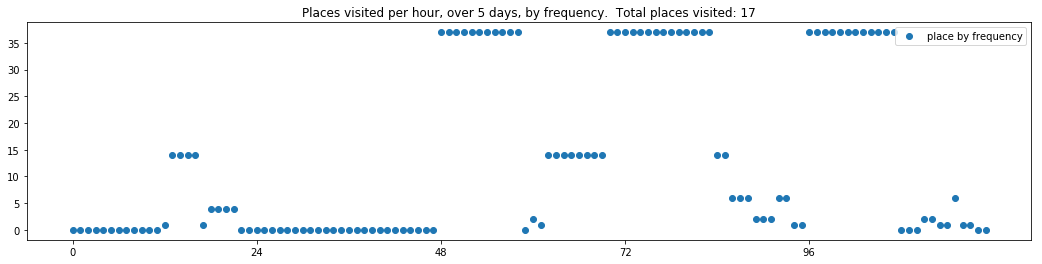

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 373, 373, 373, 373, 373, 373, 373, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 558, 373, 373, 373, 373, 373, 373, 373, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 146, 224]
[4, 4, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 4]


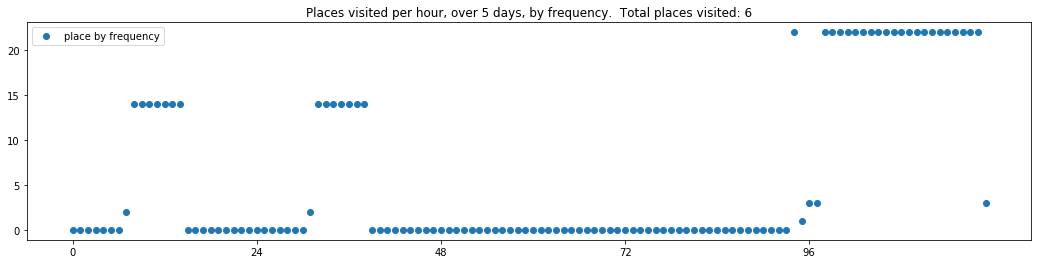

----- vector ----
prefix labels:  [558, 558]
[0, 0, 0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 434, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 558, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 258]


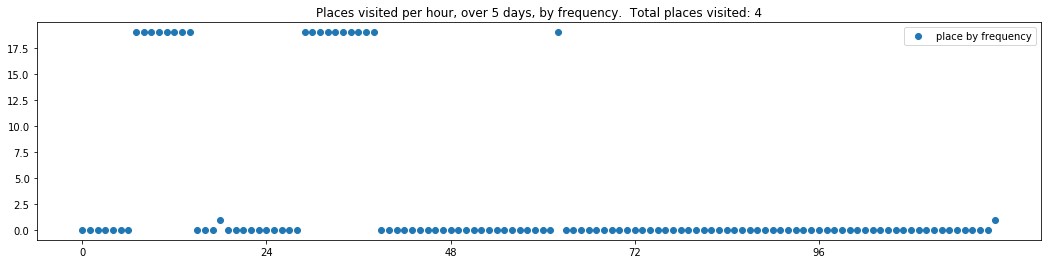

In [14]:
for tv in textgenrnn_cambridge_trajectories_set[1.0][:2*sample_size]:
    print_dwell_vector_by_days(tv)
    plot_trajectory_vector_frequencies(tv, by_frequency_order=False) 